# General

In [ ]:
# Het importeren van de benodigde bilbiotheken
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import polyfit
import seaborn as sb
import scipy.stats

In [ ]:
# Het inlezen van de bestanden
dfTelemetry = pd.read_csv('data/PdM_telemetry.csv')
dfErrors = pd.read_csv('data/PdM_errors.csv')
dfMaint = pd.read_csv('data/PdM_maint.csv')
dfFailures = pd.read_csv('data/PdM_failures.csv')
dfMachines = pd.read_csv('data/PdM_machines.csv')

In [ ]:
# #Left join failures on maintenance to create df1
df1 = pd.merge(dfMaint, dfFailures, how='left', left_on=['datetime', 'machineID', 'comp'], right_on = ['datetime', 'machineID', 'failure'])
df1['failure'] = df1['failure'].fillna(0) #indicates maint was not a failure
df1.loc[((df1.failure == 'comp1') | (df1.failure == 'comp2') | (df1.failure == 'comp3') | (df1.failure == 'comp4')), 'failure'] = '1' #indicates maintenance was a failure
df1['failure'] = df1['failure'].astype(int)

#Clean error table to create df2, df2 = cleansed dfErrors tbl. 
df2 = dfErrors
df2['Error1'] = 0
df2['Error2'] = 0
df2['Error3'] = 0
df2['Error4'] = 0
df2['Error5'] = 0

df2.loc[(df2['errorID'] == 'error1'), 'Error1'] = 1
df2.loc[(df2['errorID'] == 'error2'), 'Error2'] = 1
df2.loc[(df2['errorID'] == 'error3'), 'Error3'] = 1
df2.loc[(df2['errorID'] == 'error4'), 'Error4'] = 1
df2.loc[(df2['errorID'] == 'error5'), 'Error5'] = 1

# # df2 = df2.groupby(['machineID', 'datetime']).sum() #Groups on all cols.
df2 = df2.groupby(['datetime', 'machineID'])[[f'Error{n}' for n in range (1,6)]].sum() #Groups errorID cols only

##Create df3 by joining dfTelemetry on df2
df3 = pd.merge(dfTelemetry, df2, how='left', left_on=['machineID', 'datetime'], right_on=['machineID', 'datetime'])

df3['Error1'] = df3['Error1'].fillna(0)
df3['Error2'] = df3['Error2'].fillna(0)
df3['Error3'] = df3['Error3'].fillna(0)
df3['Error4'] = df3['Error4'].fillna(0)
df3['Error5'] = df3['Error5'].fillna(0)

df3.Error1 = df3.Error1.astype(int)
df3.Error2 = df3.Error2.astype(int)
df3.Error3 = df3.Error3.astype(int)
df3.Error4 = df3.Error4.astype(int)
df3.Error5 = df3.Error5.astype(int)

## Create df4 by joining machines on df3
df4 = pd.merge(dfMachines, df3, how='right', left_on=['machineID'], right_on=['machineID'])

## Create df5 by joining df1 on df4
df5 = pd.merge(df1, df4, how='right', left_on=['machineID', 'datetime'], right_on=['machineID', 'datetime'])
df = df5

#Create dfSmall by inner joining df1 on df4
dfSmall = pd.merge(df1, df4)

# Linear regression of age and failures w/ pearson R line

In [ ]:
failureGroupAgedf = df['failure'].groupby(df['age']).sum().reset_index()
x = failureGroupAgedf['age']
y = failureGroupAgedf['failure']

# #polynomial
a, b = polyfit(x, y, 1)

_ = plt.plot(x, y, '.', label='data')
_ = plt.plot(x, a + b * x, '-', label='fitted polynomial line')
_ = plt.legend()
plt.show()

# #Linear
# m, b = np.linalg.lstsq(failureGroupAgedf, y)[0]

# _ = plt.plot(x,y, 'o', label='original data', markersize = 10)
# _ = plt.plot(x, m*x + b, 'r', label='fitted line')
# _ = plt.legend()
# plt.show()

print(scipy.stats.pearsonr(x, y))
print(scipy.stats.spearmanr(x, y))
print(scipy.stats.kendalltau(x, y))

# print(failureGroupAgedf)

# plt.figure(figsize=[15,8])
# sb.heatmap(failureGroupAgedf.corr(),annot=True)

# Histogram with classification of voltage

In [ ]:
# volt min = 138.432075
# volt max = 255.124717
# bins: 130,140,150,160,170,180,190,200,210,220,230,240,250,260

toCut = dfSmall.volt
labelsUsed = [
    '130-140',
    '140-150',
    '150-160',
    '160-170',
    '170-180',
    '180-190',
    '190-200',
    '200-210',
    '210-220',
    '220-230',
    '230-240',
    '240-250',
    '250-260'
]

voltcat = pd.cut(toCut,bins=[130,140,150,160,170,180,190,200,210,220,230,240,250,260],
    labels=labelsUsed)
# dfSmall.insert(7,'voltage_class',voltcat) #Inserts the records into the new columns, but when executed again another code should be used(?)

## Building the graphic

# validation code to check the amount of failures within a voltage class
# test = dfSmall['failure'].groupby(dfSmall['voltage_class']).sum()
# print(test)

failureGroupVoltdf = dfSmall['failure'].groupby(dfSmall['voltage_class']).sum().reset_index()
x = failureGroupVoltdf['voltage_class']
y = failureGroupVoltdf['failure']

fig, ax = plt.subplots()
fig.set_figwidth(15)
fig.set_figheight(10)
ax.bar(x, y, label='failures per voltklasse', align='center')
ax.set_title('Aantal failures per volt klasse')
ax.set_ylabel('Aantal failures')
ax.set_xlabel('Voltklasse (V)')
ax.legend()
plt.show()


# Histogram with classification of rotation

In [32]:
dfSmall.head()

,datetime,machineID,comp,failure,model,age,volt,voltage_class,rotate,rotation_class,pressure,pressure_class,vibration,Error1,Error2,Error3,Error4,Error5
0,2015-01-05 06:00:00,1,comp4,1,model3,18,179.303153,170-180,499.777962,480-520,111.833028,110-120,52.383097,0,0,0,0,0
1,2015-01-05 06:00:00,1,comp1,0,model3,18,179.303153,170-180,499.777962,480-520,111.833028,110-120,52.383097,0,0,0,0,0
2,2015-01-20 06:00:00,1,comp3,0,model3,18,157.774510,150-160,442.816748,440-480,105.160692,100-110,42.135127,0,0,0,0,0
3,2015-01-20 06:00:00,1,comp1,0,model3,18,157.774510,150-160,442.816748,440-480,105.160692,100-110,42.135127,0,0,0,0,0
4,2015-02-04 06:00:00,1,comp4,0,model3,18,198.120032,190-200,438.210053,400-440,89.040265,80-90,41.887215,0,0,0,0,0


In [ ]:
# rotation min = 207.448002
# rotation max = 619.694725
# bins: 200, 240, 280, 320, 360, 400, 440, 480, 520, 560, 600, 640

dfSmall['rotate'].describe()

toCut = dfSmall.rotate
labelsUsed = [
    '200-240',
    '240-280',
    '280-320',
    '320-360',
    '360-400',
    '400-440',
    '440-480',
    '480-520',
    '520-560',
    '560-600',
    '600-640'
]

rotatecat = pd.cut(toCut,bins=[200, 240, 280, 320, 360, 400, 440, 480, 520, 560, 600, 640],
    labels=labelsUsed)
# dfSmall.insert(9,'rotation_class',rotatecat) #Inserts the records into the new columns, but when executed again another code should be used(?)

## Building the graphic

# validation code to check the amount of failures within a rotation class
# test = dfSmall['failure'].groupby(dfSmall['rotation_class']).sum()
# print(test)

failureGroupRotatedf = dfSmall['failure'].groupby(dfSmall['rotation_class']).sum().reset_index()
x = failureGroupRotatedf['rotation_class']
y = failureGroupRotatedf['failure']

fig, ax = plt.subplots()
fig.set_figwidth(15)
fig.set_figheight(10)
ax.bar(x, y, label='failures per rotatie klasse', align='center')
ax.set_title('Aantal failures per rotatie klasse')
ax.set_ylabel('Aantal failures')
ax.set_xlabel('Rotatieklasse')
ax.legend()
plt.show()


# Histogram with classification of pressure

In [ ]:
# pressure min = 69.759427
# pressure max = 168.992513
# bins: 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170

toCut = dfSmall.pressure
labelsUsed = [
    '60-70',
    '70-80',
    '80-90',
    '90-100',
    '100-110',
    '110-120',
    '120-130',
    '130-140',
    '140-150',
    '150-160',
    '160-170'
]

pressurecat = pd.cut(toCut,bins=[60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170],
    labels=labelsUsed)
# dfSmall.insert(11,'pressure_class',pressurecat) #Inserts the records into the new columns, but when executed again another code should be used(?)

## Building the graphic

# validation code to check the amount of failures within a rotation class
test = dfSmall['pressure'].groupby(dfSmall['pressure_class']).sum()
print(test)

pressureGroupRotatedf = dfSmall['failure'].groupby(dfSmall['pressure_class']).sum().reset_index()
x = pressureGroupRotatedf['pressure_class']
y = pressureGroupRotatedf['failure']

fig, ax = plt.subplots()
fig.set_figwidth(15)
fig.set_figheight(10)
ax.bar(x, y, label='failures per druk klasse', align='center')
ax.set_title('Aantal failures per druk klasse')
ax.set_ylabel('Aantal failures')
ax.set_xlabel('Druk klasse')
ax.legend()
plt.show()


# Histogram with classification of vibration

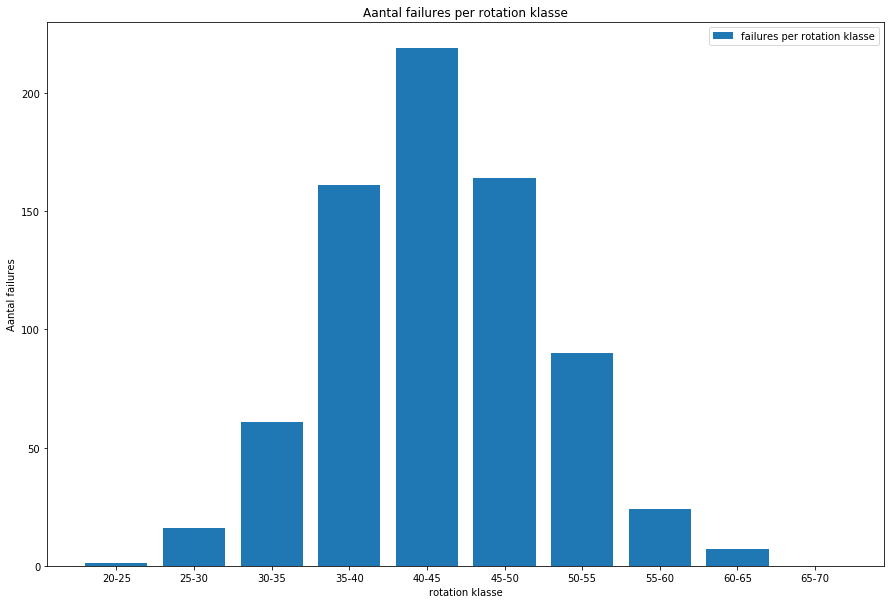

In [42]:
# vibration min = 21.952829
# vibration max = 63.246018
# bins: 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70

dfSmall['vibration'].describe()

toCut = dfSmall.vibration
labelsUsed = [
    '20-25',
    '25-30',
    '30-35',
    '35-40',
    '40-45',
    '45-50',
    '50-55',
    '55-60',
    '60-65',
    '65-70'
]

vibrationcat = pd.cut(toCut,bins=[20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70],
    labels=labelsUsed)
# dfSmall.insert(13,'vibration_class',vibrationcat) #Inserts the records into the new columns, but when executed again another code should be used(?)

## Building the graphic

# validation code to check the amount of failures within a rotation class
# test = dfSmall['vibration'].groupby(dfSmall['vibration_class']).sum()
# print(test)

vibrationGroupRotatedf = dfSmall['failure'].groupby(dfSmall['vibration_class']).sum().reset_index()
x = vibrationGroupRotatedf['vibration_class']
y = vibrationGroupRotatedf['failure']

fig, ax = plt.subplots()
fig.set_figwidth(15)
fig.set_figheight(10)
ax.bar(x, y, label='failures per rotation klasse', align='center')
ax.set_title('Aantal failures per rotation klasse')
ax.set_ylabel('Aantal failures')
ax.set_xlabel('rotation klasse')
ax.legend()
plt.show()